<a href="https://colab.research.google.com/github/jaekyoungkim/my_project/blob/main/HAN_applied_to_mimic3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 참고 논문 : Description-based Label Attention Classifier for Explainable ICD-9 Classification
# https://git.io/JzOyk
# https://cpm0722.github.io/pytorch-implementation/transformer 
# https://hugrypiggykim.com/2018/12/09/bert-pre-training-of-deep-bidirectional-transformers-for-language-understanding/

In [1]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.107.38.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.107.38.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [ ]:
# 해당 모델을 fit 하게되면 TPU로 학습하게됨
#with strategy.scope():
#  model = create_model()
#  model.compile(optimizer='adam',
#                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                metrics=['sparse_categorical_accuracy'])

# Settings 

In [2]:
# 구글드라이브에 핸들링한 데이터 넣어둠
# .(마침표) 남겨둔 데이터 FOR sentence 나누기
# 파일명 : notes_labeled_binarized / notes_labeled_50_binarized

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import keras
from keras import backend as K
import tensorflow as tf
#from keras.engine.topology import Layer 수정해야함
#from tensorflow.python.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Input, Embedding, Dense
from keras.layers import Lambda, Permute, RepeatVector, Multiply
from keras.layers import Bidirectional, TimeDistributed
from keras.layers import CuDNNGRU, GRU
from keras.layers import BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import nltk

import numpy as np
from keras.preprocessing.text import Tokenizer  # 토큰화하는 패키지
from keras.preprocessing.sequence import pad_sequences # padding 을 위한 패키지
from tensorflow.keras.utils import to_categorical #from keras.utils import to_categorical # 범주형 변수로 만들어줌 / 실행안되는 이유확인
from nltk.tokenize import sent_tokenize  # 문장을 token화 시킴
import nltk
from nltk import word_tokenize

nltk.download('punkt')
import gc




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Dataset 

In [4]:
final_data = pd.read_csv('gdrive/MyDrive/dataset/mimic data/final_data.csv')  #  encoding = 'c==p949' 생략

In [129]:
# final_data의 text에서 각 document마다 period가 몇번 등장하는지 확인해보고자 함. period를 사용하지 않은 데이터도 있지 않을까 의심되어 확인해봄
all_text = final_data['TEXT']

In [115]:
myString = all_text[1]
print(myString.count('.'))

120


In [135]:
print(len(all_text))
print(type(all_text))
all_text_df = pd.DataFrame(all_text)

12808
<class 'pandas.core.series.Series'>


In [133]:
all_text[1].count('.')

120

In [139]:
for i in range(len(all_text)):
  all_text_df['number_of_period'][i] = all_text[i].count('.')   # 12808

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [142]:
all_text_df.head(3)

,TEXT,number_of_period
0,admission date date of birth service cardiotho...,58
1,admission date date of birth service history o...,120
2,admission date date of birth service cardiotho...,72


In [143]:
all_text_df.shape

(12808, 2)

In [145]:
min(all_text_df['number_of_period'])  # period가 없는 문장이 존재함

0

In [154]:
all_text_df[all_text_df['number_of_period']<5]  # 72개의 document에서 period가 발견되지 않음 # 해당 데이터는 제거하고 실행해야할것으로 보임 / period가 거의 안사용되는 문장들도 존재함을 알 수 있음

,TEXT,number_of_period
80,name admission date date of birth service adde...,3
136,name admission date date of birth service adde...,4
138,y name admission date date of birth service di...,2
139,name admission date date of birth service the ...,3
159,name admission date date of birth service card...,4
...,...,...
12696,name admission date date of birth service neur...,1
12715,name admission date date of birth service card...,1
12752,name admission date date of birth service surg...,2
12759,name admission date date of birth service orth...,2


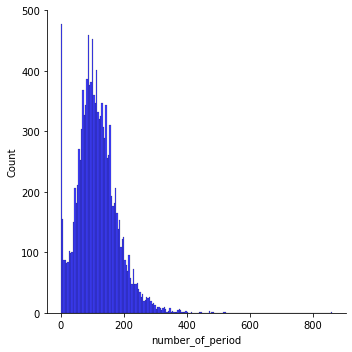

In [152]:
sns.displot(all_text_df['number_of_period'],  bins = 200, color = "blue") 

In [5]:
final_data.columns

Index(['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID', 'TEXT', 'LABELS', '038.9',
       '244.9', '250.00', '272.0', '272.4', '276.1', '276.2', '285.1', '285.9',
       '287.5', '305.1', '311', '33.24', '36.15', '37.22', '37.23', '38.91',
       '38.93', '39.61', '39.95', '401.9', '403.90', '410.71', '412', '414.01',
       '424.0', '427.31', '428.0', '45.13', '486', '496', '507.0', '511.9',
       '518.81', '530.81', '584.9', '585.9', '599.0', '88.56', '88.72',
       '96.04', '96.6', '96.71', '96.72', '99.04', '99.15', '995.92', 'V15.82',
       'V45.81', 'V58.61'],
      dtype='object')

In [6]:

# long sentence 할때 이 부분 숫자를 조정해야할듯
# 데이터에서 max(sentence) 값을 적용해야할듯

MAX_SENTENCES = 300 # 10 : 몇개의 문장
MAX_SENTENCE_LENGTH = 50 # 25 :문장마다의 길이


In [7]:
# train / test
# y값 : top50의 하나씩 대입시킴
train_x_data = final_data['TEXT'][:8000]
train_y_data = final_data['244.9'][:8000]  
test_x_data = final_data['TEXT'][8000:]
test_y_data = final_data['244.9'][8000:]  

print("len(train_x_data): {}".format(len(train_x_data))) # 10000 / 8000
print("len(test_x_data): {}".format(len(test_x_data))) # 2808 / 4808


len(train_x_data): 8000
len(test_x_data): 4808


In [10]:
# train / test
train_x_data = final_data['TEXT'][:8000]
train_y_data = final_data[['038.9','244.9', '250.00', '272.0', '272.4', '276.1', '276.2', '285.1', '285.9', '287.5', '305.1',
                           '311', '33.24', '36.15', '37.22', '37.23', '38.91','38.93', '39.61', '39.95', '401.9', '403.90',
                           '410.71', '412', '414.01','424.0', '427.31', '428.0', '45.13', '486', '496', '507.0', '511.9',
                           '518.81', '530.81', '584.9', '585.9', '599.0', '88.56', '88.72', '96.04', '96.6', '96.71', '96.72',
                           '99.04', '99.15', '995.92', 'V15.82', 'V45.81', 'V58.61']][:8000]
test_x_data = final_data['TEXT'][8000:]
test_y_data = final_data[['038.9','244.9', '250.00', '272.0', '272.4', '276.1', '276.2', '285.1', '285.9', '287.5', '305.1', '311', '33.24', '36.15', '37.22', '37.23', '38.91','38.93', '39.61', '39.95', '401.9', '403.90', '410.71', '412', '414.01','424.0', '427.31', '428.0', '45.13', '486', '496', '507.0', '511.9', '518.81', '530.81', '584.9', '585.9', '599.0', '88.56', '88.72', '96.04', '96.6', '96.71', '96.72', '99.04', '99.15', '995.92', 'V15.82', 'V45.81', 'V58.61']][8000:]

print("len(train_x_data): {}".format(len(train_x_data))) # 10000 / 8000
print("len(test_x_data): {}".format(len(test_x_data))) # 
print("len(train_y_data): {}".format(len(train_y_data))) # 
print("len(test_y_data): {}".format(len(test_y_data))) #

len(train_x_data): 8000
len(test_x_data): 4808
len(train_y_data): 8000
len(test_y_data): 4808


In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x_data)
tokenizer.fit_on_texts(test_x_data)
len(tokenizer.word_index) # 63993


63993

In [ ]:
max_nb_words = len(tokenizer.word_index) + 1  # 토큰나이즈했을때에 나타나는 단어개수만큼
max_nb_words

63994

In [13]:
train_x_data[0]

"admission date date of birth service cardiothoracic allergies bactrim ampicillin remeron attending chief complaint chest pressure cardiac tamponade cardiogenic shock major surgical or invasive procedure emergent sternotomy for pericardial window history of present illness underwent min. inv. pfo closure in on and chest pain for several days. did not resolve with pain med and had increasing sob. admitted to er for emergent eval. and bedside tte. started on dopamine drip for hypotension. past medical history s p min. inv. closure of patent foramen ovale stroke tia depression anxiety borderline hyperlipidemia herniation of cervical discs patella femoral syndrome s p bunionectomies social history denies tobacco. admits to occasional etoh. she is an employee of the children. she denies ivda and recreational drugs. family history father underwent cabg at age . cousin died of an mi at age . physical exam pt. in distress sbp 's lungs cta tachycardic rr no murmur or rubs palpable pedal pulses 

In [ ]:
sent_tokenize(train_x_data[0])

['admission date date of birth service cardiothoracic allergies bactrim ampicillin remeron attending chief complaint chest pressure cardiac tamponade cardiogenic shock major surgical or invasive procedure emergent sternotomy for pericardial window history of present illness underwent min.',
 'inv.',
 'pfo closure in on and chest pain for several days.',
 'did not resolve with pain med and had increasing sob.',
 'admitted to er for emergent eval.',
 'and bedside tte.',
 'started on dopamine drip for hypotension.',
 'past medical history s p min.',
 'inv.',
 'closure of patent foramen ovale stroke tia depression anxiety borderline hyperlipidemia herniation of cervical discs patella femoral syndrome s p bunionectomies social history denies tobacco.',
 'admits to occasional etoh.',
 'she is an employee of the children.',
 'she denies ivda and recreational drugs.',
 'family history father underwent cabg at age .',
 'cousin died of an mi at age .',
 'physical exam pt.',
 "in distress sbp 's 

In [78]:
sent = []
word_count = []
sent_one = []
for i in range(len(train_x_data)):
  sent_one.append(sent_tokenize(train_x_data[i])) # i번째 document 기준
  sent.append(len(sent_one[i])) # 각 document마다 나다타는 문장의 수를 보여줌 
  for j in range(len(sent_one[i])):  # 각 document의 문장마다의 token개수를 word_count에 계속 추가함
    word_count.append(len(sent_one[i][j]))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

8000
452
81.0
86.5865
150.0


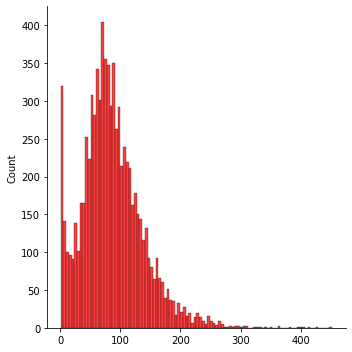

In [159]:
print(len(sent)) # train document의 숫자
print(max(sent)) # DOCUMNET하나에서 나타나는 최대 문장개수는 452
print(np.median(sent)) # 81.0
print(np.mean(sent)) # DOCUMNET하나에서 나타나는 평균 문장개수는 86.58
print(np.quantile(sent, 0.9)) # 150
sns.displot(sent,  bins = 100, color = "red")  # 200아래에서 거의 존재함

In [158]:
print(len(sent_one))
print(len(word_count))  # 전체 document의 문장의수는 692692
print(np.mean(word_count)) #문장마다의 평균 토큰수는 80.5
print(max(word_count)) #문장에서 나타나는 최대 토큰수는 2323
print(np.quantile(word_count, 0.9)) # 90quantile : 167.0

8000
692692
80.58640636819828
2323
167.0


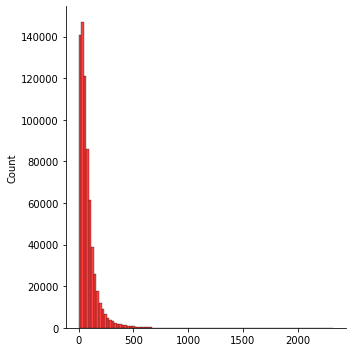

In [98]:
sns.displot(word_count,  bins = 100, color = "red")  # 거의 대부분이 200이하임을 알 수 있음

[287,
 4,
 50,
 53,
 33,
 16,
 41,
 29,
 4,
 191,
 26,
 35,
 39,
 45,
 29,
 17,
 111,
 6,
 5,
 13,
 3,
 220,
 42,
 101,
 34,
 78,
 31,
 36,
 76,
 61,
 73,
 24,
 70,
 23,
 38,
 35,
 16,
 32,
 11,
 68,
 23,
 84,
 23,
 59,
 23,
 68,
 23,
 35,
 28,
 178,
 455,
 247,
 37,
 55,
 89,
 40,
 13,
 10,
 29,
 13,
 18,
 24,
 25,
 13,
 12,
 14,
 12,
 14,
 16,
 15,
 46,
 6,
 85,
 44,
 47,
 29,
 10,
 12,
 12,
 19,
 39,
 59,
 27,
 22,
 87,
 65,
 71,
 29,
 12,
 33,
 28,
 9,
 99,
 54,
 144,
 57,
 83,
 136,
 26,
 53,
 42,
 63,
 40,
 26,
 164,
 37,
 16,
 12,
 28,
 15,
 17,
 19,
 21,
 16,
 21,
 254,
 44,
 80,
 165,
 28,
 256,
 131,
 151,
 82,
 87,
 72,
 107,
 363,
 41,
 40,
 183,
 126,
 125,
 240,
 113,
 178,
 121,
 171,
 151,
 135,
 107,
 95,
 24,
 23,
 13,
 25,
 27,
 25,
 14,
 36,
 28,
 23,
 17,
 19,
 21,
 21,
 6,
 91,
 93,
 38,
 76,
 54,
 117,
 125,
 28,
 473,
 22,
 59,
 95,
 42,
 69,
 59,
 24,
 40,
 66,
 47,
 28,
 62,
 25,
 51,
 19,
 48,
 50,
 47,
 11,
 22,
 37,
 51,
 24,
 127,
 31,
 188,
 160,
 109,
 1

In [72]:
print(sent_one) 

['admission date date of birth service cardiothoracic allergies no known allergies adverse drug reactions attending chief complaint chest pain major surgical or invasive procedure procedures .', 'third time redo sternotomy.second time aortic valve replacement with a mm onyx mechanical valve reference number number .', 'redo cabg times with reverse saphenous vein graft from the neo ascending aorta to the preexisting saphenous vein graft to the right coronary artery reverse saphenous vein graft from the neo ascending aorta to the preexisting om vein graft.endoscopic vein harvesting.replacement of ascending aorta with a mm tube graft using deep hypothermic circulatory arrest .', 'sternal re exploration removal of packing and sternal closure history of present illness mr. with month of worsening cp on exertion and doe.', 'approximately month ago mr. doe which have been worsening over the last weeks.', 'approximately week ago he also noted resting shoulder pain and nocturnal cough.', 'pain 

In [64]:
np.mean(word_count) # 80.58640636819828

80.58640636819828

In [65]:
len(word_count) # 총문장의 개수는 692692

692692

In [51]:
word_token = tokenizer.texts_to_sequences(sent_one)
len(word_token[2])

56

In [54]:
print(word_token[0])
print(len(word_token[0]))

[40, 61, 61, 3, 206, 100, 1029, 130, 12, 279, 130, 1407, 460, 1409, 237, 259, 247, 63, 41, 244, 139, 18, 239, 136, 2416]
25


In [49]:
len(word_token)

114

In [32]:
sent_one

['admission date date of birth service cardiothoracic allergies no known allergies adverse drug reactions attending chief complaint chest pain major surgical or invasive procedure procedures .',
 'third time redo sternotomy.second time aortic valve replacement with a mm onyx mechanical valve reference number number .',
 'redo cabg times with reverse saphenous vein graft from the neo ascending aorta to the preexisting saphenous vein graft to the right coronary artery reverse saphenous vein graft from the neo ascending aorta to the preexisting om vein graft.endoscopic vein harvesting.replacement of ascending aorta with a mm tube graft using deep hypothermic circulatory arrest .',
 'sternal re exploration removal of packing and sternal closure history of present illness mr. with month of worsening cp on exertion and doe.',
 'approximately month ago mr. doe which have been worsening over the last weeks.',
 'approximately week ago he also noted resting shoulder pain and nocturnal cough.',
 

In [23]:
print(type(sent))
sent_df = pd.DataFrame(sent)
sent_df.shape #(8000, 1) 
sent_df

<class 'list'>


,0
0,51
1,69
2,45
3,45
4,153
...,...
7995,93
7996,69
7997,118
7998,155


In [22]:
print(max(sent)) # 452 : 각 document 1개 안에 있는 문장의 개수
print(np.mean(sent)) # 90.2226 : 평균적인 길이
print(min(sent)) # 1
print(len(sent))

452
86.5865
1
8000


원본 : "Admission Date:  [**2135-5-9**]              Discharge Date:   [**2135-5-13**]

Date of Birth:  [**2087-7-14**]             Sex:   F

Service: CARDIOTHORACIC

Allergies:
Bactrim / Ampicillin / Remeron

Attending:[**First Name3 (LF) 1283**]
Chief Complaint:
chest pressure/cardiac tamponade/ cardiogenic shock

Major Surgical or Invasive Procedure:
emergent sternotomy for pericardial window  [**2135-5-9**]


History of Present Illness:
Underwent min. inv. PFO closure in [**12-11**]. Had emergent admission
on [**5-9**] for hypotension, pericardial effusion , pleural effusion
and chest pain for several days. Did not resolve with pain med
and had increasing SOB. Admitted to ER for emergent eval. and
bedside TTE. Started on dopamine drip for hypotension.

Past Medical History:
s/p min. inv. closure of Patent foramen ovale [**12-11**]; History of
Stroke/TIA; Depression; Anxiety; Borderline Hyperlipidemia;
Herniation of Cervical Discs; Patella-Femoral Syndrome; s/p
Bunionectomies

Social History:
Denies tobacco. Admits to occasional ETOH. She is an employee of
the [**Hospital1 18**] in the Neuro-Pysch Department. She is married with two
children. She denies IVDA and recreational drugs.


Family History:
Father underwent CABG at age 72. Cousin died of an MI at age 46.

Physical Exam:
pt. in distress
SBP 70- 80's
lungs CTA
tachycardic, RR, no murmur or rubs
palpable pedal pulses

Pertinent Results:
[**2135-5-11**] 08:40AM BLOOD WBC-11.3* RBC-3.62* Hgb-9.9* Hct-28.8*
MCV-80* MCH-27.3 MCHC-34.3 RDW-14.4 Plt Ct-413
[**2135-5-9**] 11:45AM BLOOD Neuts-86.5* Lymphs-7.0* Monos-5.2 Eos-1.2
Baso-0.2
[**2135-5-11**] 08:40AM BLOOD Plt Ct-413
[**2135-5-11**] 08:40AM BLOOD Glucose-118* UreaN-8 Creat-0.6 Na-136
K-3.7 Cl-102 HCO3-24 AnGap-14
[**2135-5-9**] 11:45AM BLOOD CK(CPK)-26
[**2135-5-9**] 11:45AM BLOOD CK-MB-NotDone cTropnT-<0.01

Brief Hospital Course:
Admitted through ER as above and referred to CT [**Doctor First Name **] for
emergent pericardial window/pericardectomy via sternotomy, as
the patient was hypotensive.This was performed by Dr. [**Last Name (STitle) 1290**]
on [**5-9**]. Transferred to CSRU in stable condition on phenylephrine
and propofol drips. Extubated and awoke neurologically intact.
Beta blockade started on POD #1 and transferred out to the floor
to start increasing her activity level. Mediastinal tubes
removed on POD #1. Crepitus was noted on anterior chest wall
after pleural tubes removed on POD #2. Beta blockade also
titrated up. Crepitus improved and CXR confirmed. She made good
progress and was discharged to home with VNA services on POD #4.

Medications on Admission:
ASA 325 mg daily


Discharge Medications:
1. Docusate Sodium 100 mg Capsule Sig: One (1) Capsule PO BID (2
times a day) for 1 months.
Disp:*60 Capsule(s)* Refills:*0*
2. Ranitidine HCl 150 mg Tablet Sig: One (1) Tablet PO BID (2
times a day) for 1 months.
Disp:*60 Tablet(s)* Refills:*0*
3. Aspirin 81 mg Tablet, Delayed Release (E.C.) Sig: One (1)
Tablet, Delayed Release (E.C.) PO DAILY (Daily).
Disp:*30 Tablet, Delayed Release (E.C.)(s)* Refills:*2*
4. Acetaminophen 325 mg Tablet Sig: Two (2) Tablet PO Q4H (every
4 hours) as needed.
Disp:*30 Tablet(s)* Refills:*0*
5. Oxycodone-Acetaminophen 5-325 mg Tablet Sig: 1-2 Tablets PO
Q4H (every 4 hours) as needed for pain.
Disp:*40 Tablet(s)* Refills:*0*
6. Furosemide 20 mg Tablet Sig: One (1) Tablet PO once a day for
3 days.
Disp:*3 Tablet(s)* Refills:*0*
7. Potassium Chloride 20 mEq Packet Sig: One (1) Packet PO once
a day for 3 days.
Disp:*3 Packet(s)* Refills:*0*
8. Metoprolol Tartrate 25 mg Tablet Sig: 1.5 Tablets PO BID (2
times a day).
Disp:*90 Tablet(s)* Refills:*1*


Discharge Disposition:
Home With Service

Facility:
[**Company 1519**]

Discharge Diagnosis:
s/p emergent pericardial window via sternotomy [**2135-5-9**]
cardiogenic shock/tamponade
s/p Min inv. PFO closure [**12-11**]
s/p CVA
anxiety/depression
cervical disc herniation
patella-femoral syndrome
borderline hyperlipidemia


Discharge Condition:
stable


Discharge Instructions:
may shower over incision and gently pat dry
no lotions, creams or powders on incision
no driving for one month
no lifting greater than 10 pounds for 10 weeks
call for fever greater than 100, redness or drainage

Followup Instructions:
follow up with Dr. [**Last Name (STitle) **] (PCP) in [**2-7**] weeks
follow up with Dr. [**Last Name (STitle) **] (Card)in [**3-11**] weeks
follow up with Dr. [**Last Name (STitle) 1290**] in 4 weeks   [**Telephone/Fax (1) 170**]



Completed by:[**2135-5-13**]"

In [ ]:
def doc2hierarchical(text,
                     max_sentences=MAX_SENTENCES,  # 위에서 정의한값
                     max_sentence_length=MAX_SENTENCE_LENGTH):  # 위에서 정의한값
    sentences = sent_tokenize(text)  # 긴문장을 문장 단위로 쪼개줌
    tokenized_sentences = tokenizer.texts_to_sequences(sentences)
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen=max_sentence_length)  # 패딩을 써서 길이를 맞춰춤

    pad_size = max_sentences - tokenized_sentences.shape[0]

    if pad_size <= 0:  # tokenized_sentences.shape[0] < max_sentences
        tokenized_sentences = tokenized_sentences[:max_sentences]  # 패딩사이즈를 넘어가면 중간에 잘라주어야함
    else:
        tokenized_sentences = np.pad(
            tokenized_sentences, ((0, pad_size), (0, 0)),
            mode='constant', constant_values=0
        )

    return tokenized_sentences


def build_dataset(x_data, y_data,
                  max_sentences=MAX_SENTENCES,
                  max_sentence_length=MAX_SENTENCE_LENGTH,
                  tokenizer=tokenizer):
    nb_instances = len(x_data)
    X_data = np.zeros((nb_instances, max_sentences, max_sentence_length), dtype='int32')
    for i, review in enumerate(x_data):
        tokenized_sentences = doc2hierarchical(review)

        X_data[i] = tokenized_sentences[None, ...]

    nb_classes = len(set(y_data))  # 0,1 : 2개 카테고리 > 2값이 나옴
    Y_data = to_categorical(y_data, nb_classes)  # 1/0 binary를 2개의 컬럼으로 나타냄 / one-hot encoding과 같음
    # Y_data = y_data
    return X_data, Y_data

In [ ]:
len(set(train_y_data))

2

In [ ]:
train_X_data, train_Y_data = build_dataset(train_x_data, train_y_data)
test_X_data, test_Y_data = build_dataset(test_x_data, test_y_data)

train_X_data[1][1]
train_X_data[1]

print("train_X_data.shape: {}".format(train_X_data.shape)) # (10000, 300, 30)
print("test_X_data.shape: {}".format(test_X_data.shape)) # 
print("train_Y_data.shape: {}".format(train_Y_data.shape)) # (10000, 300, 30)
print("test_Y_data.shape: {}".format(test_Y_data.shape)) # 

train_X_data.shape: (8000, 300, 50)
test_X_data.shape: (4808, 300, 50)
train_Y_data.shape: (8000, 2)
test_Y_data.shape: (4808, 2)


In [ ]:
train_Y_data

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
train_X_data[1].shape

(300, 50)

In [ ]:
train_X_data

array([[[    0,     0,     0, ...,   189,   399,  1200],
        [    0,     0,     0, ...,     0,     0, 15756],
        [    0,     0,     0, ...,    11,   420,    94],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    0,     0,     0, ...,     1, 11876,   551],
        [    0,     0,     0, ...,    18,   569,    41],
        [    0,     0,     0, ...,   538,   352,    71],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    0,     0,     0, ...,    10,   101,    83],
        [    0,     0,     0, ...,     3,    63,    41],
        [    0,     0,     0, ...,  1772,  2130,   118],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,    

In [ ]:
train_Y_data[1].shape

(2,)

In [ ]:
train_Y_data.shape # (800, 50, 50)

(8000, 2)

In [ ]:
train_X_data[1]

array([[    0,     0,     0, ...,     1, 11876,   551],
       [    0,     0,     0, ...,    18,   569,    41],
       [    0,     0,     0, ...,   538,   352,    71],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]], dtype=int32)

In [ ]:
len(train_X_data[1][2])

50

In [ ]:
# train-valid test split (9:1)
from sklearn.model_selection import train_test_split
# train -> train과 valid로 나누기
train_X_data, val_X_data, train_Y_data, val_Y_data = train_test_split(train_X_data, train_Y_data, test_size=0.1,random_state=42)
print("train_X_data.shape: {}".format(train_X_data.shape))
print("train_Y_data.shape: {}".format(train_Y_data.shape))
print("val_X_data.shape: {}".format(val_X_data.shape))
print("val_Y_data.shape: {}".format(val_Y_data.shape))

train_X_data.shape: (7200, 300, 50)
train_Y_data.shape: (7200, 2)
val_X_data.shape: (800, 300, 50)
val_Y_data.shape: (800, 2)


# word2vec embedding 

In [ ]:
# google이 이미 word2vec의 결과로 각 word에 대한 vector를 만들어서 배포
# 하지만 용량이 커서 작은 용량에서는 어렵죠. 그래서 작은 용량의 word2vec vector로 존재
# vector를 특정 분야에 맞게 특화시키킬 원할 경우,
# Word2vec.intersect_word2vec_format(googleNews_filepath, binary=True, lockf=1.0)을 통해 쉽게 초기값을 설정
# word2vec-GoogleNews-vectors에서 이미 학습된 word2vector를 다운가능
# 다만, 학습된 모델을 가져오는 것이 아니라, “학습된 vector”만을 수치로 가져오는 것이죠.
# 다운로드 받아놓은게 있어서 따로 다운받을 필요 없을듯
#import gensim.downloader as api
#wv = api.load('word2vec-google-news-300')
#vec_king = wv['king']

#embedding_dir = '/home/kjk88/TBM_DBLAC', # 파일 넣은 위치

# word2vec을 가져옴
def load_word2vec(tokenizer=tokenizer):
    from gensim.models import KeyedVectors
    embedding_path = '/content/gdrive/MyDrive/dataset/word2vec/GoogleNews-vectors-negative300.bin'  # embedding_dir 위치에 다운로드 받은 파일을 넣기 다운받는데 시간이 좀 걸림
    # embedding_path = os.path.join(embedding_dir,'GoogleNews-vectors-negative300.bin')
    # https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz 해당링크에서 파일 다운로드 1.5GB정도됨
    embeddings_index = KeyedVectors.load_word2vec_format(embedding_path, binary=True)

    return embeddings_index  # embedding_index 를 불러옴, 예를들면 dog라는 단어가 있으면 dog의  index 500 을 가져옴


def load_embedding(embedding_type='word2vec',
                   tokenizer=tokenizer,
                   embedding_dim=300):
    if embedding_type == 'word2vec':
        embeddings_index = load_word2vec()  # 위에서 언급한 함수가 사용됨 load_word2vec

    embedding_matrix = np.random.normal(0, 1, (max_nb_words, embedding_dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = embeddings_index[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix
    # dog라른 단어가 있으면 해당 index를 구하고 해당 index를 찾아서 이에 대한 벡터를 가져옴
    # 전체 사용한 단어에 대해서 이에 대한 벡터 매트릭스를 생성해줌
    # 여기서는 124253단어에 대해서 해당 벡터를 전부 가져올 수 있음

embedding_matrix = load_embedding('word2vec')

print("embedding_matrix.shape: {}".format(embedding_matrix.shape)) # (652, 300)
embedding_matrix # 총 63994 개의 단어들을 각각 300차원으로 만들어서 표현함
embedding_matrix.shape #(63994, 300)

embedding_matrix.shape: (63994, 300)


(63994, 300)

In [ ]:
embedding_matrix

array([[-0.18121326,  0.80678311,  1.51455157, ..., -0.12010355,
        -0.41548121,  0.2588295 ],
       [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [ 0.07440108,  0.8755278 , -0.1559248 , ..., -0.66754624,
        -0.19618672, -0.4099477 ],
       ...,
       [ 1.05447101,  1.49177174,  2.02222064, ..., -0.27773957,
         0.38075151, -1.09616873],
       [ 0.75366611,  1.25770479,  1.31101535, ...,  0.55714529,
        -1.08523258,  1.14489413],
       [-1.40338528,  1.27151336, -0.72773532, ..., -1.29574431,
         0.07013679, -1.22718285]])

# evaluation metrics 

In [ ]:
# evaluation function 3가지
def recall(y_target, y_pred):  # 2개 요소 실제값, 예측값 필요
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1))  # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))  # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn)

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # TP = y_target_yn * y_pred_yn
    # FN = y_target_yn - (y_target_yn * y_pred_yn)

    # return a single tensor value
    return recall

def precision(y_target, y_pred):  # 2개 요소 실제값, 예측값 필요
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))  # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1))  # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn)

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # FP = y_pred_yn - (y_target_yn * y_pred_yn)

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):  # 2개 요소 실제값, 예측값 필요
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = (2 * _recall * _precision) / (_recall + _precision + K.epsilon())

    # return a single tensor value
    return _f1score


# layers setting

In [ ]:
class AttentionLayer(Layer):  # Layer를 가져옴
    def __init__(self, attention_dim, **kwargs):  # **kwargs : list가져올때 씀
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)  # attentionlayer의 속성을 가져옴

    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',  # attention 값 이값을 확인해야하는것 같음
                                 shape=(input_shape[-1], self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)  # 학습가능
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim,),  # attention값과 쌍을 이룸?
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',  # u: context vector
                                 shape=(self.attention_dim, 1),  # attention값과 쌍을 이룸?
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)  # hiddenlayer와의 계산
        a_it = K.dot(u_it, self.u)  # a가 attention을 의미함 word attention이라고 볼 수 있음
        a_it = K.squeeze(a_it, -1)  # 일자형태로 만들기
        a_it = K.softmax(a_it)  # softmax함수 적용 합이1이 되게함

        return a_it

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])


def WeightedSum(attentions, representations):  #
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation  # 합쳐진 representation


In [ ]:
def HieAtt(embedding_matrix,  # word2vec한 값
           max_sentences,
           max_sentence_length,
           nb_classes,  # 클래스의 개수 여기서는 2개
           embedding_dim=300,  # 임베딩 차원 여기서는 300차원으로 변환시킴
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    # Use tf.keras.optimizers.Adam(learning_rate) instead of keras.optimizers.Adam(learning_rate)

    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1  # 124253-1
    embedding_layer = Embedding(max_nb_words + 1,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,  # input
                                trainable=False)  # embedding한걸 다시 학습할 필요없음

    # first, build a sentence encoder
    sentence_input = Input(shape=(max_sentence_length,), dtype='int32')
    embedded_sentence = embedding_layer(sentence_input)  # sentence에 대한 임베딩 / sentence단위의 임베딩으로 한단계 위
    embedded_sentence = Dropout(dense_dropout)(embedded_sentence)
    contextualized_sentence = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_sentence)  # CuDNNGRU
    # embedded sentence 를 bidirectional featrue2개가 생성되고 두개가 합쳐짐

    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sentence)  # 위에서 설정한 attentionlayer함수사용
    sentence_representation = WeightedSum(word_attention, contextualized_sentence)  # 위에서 설정한 weightedsum 함수사용

    sentence_encoder = Model(inputs=[sentence_input],  # from keras.models import Model,
                             outputs=[sentence_representation])  # sentence를 벡터로 표현하는 과정

    # then, build a document encoder (최종 아웃풋임)
    document_input = Input(shape=(max_sentences, max_sentence_length), dtype='int32')
    embedded_document = TimeDistributed(sentence_encoder)(document_input)
    contextualized_document = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_document)  # CuDNNGRU
    # sentence를 이용해서 doc에 대한 representation v계산

    # sentence attention computation
    sentence_attention = AttentionLayer(attention_dim)(contextualized_document)
    # 해당 코드에서 가장 중요한 부분 : sentence_attention  각 sentence별 attention값이 계산되는것을 확인
    document_representation = WeightedSum(sentence_attention, contextualized_document)
    # doc에 대해 하나로 표현가능한 vector값이 나오게됨

    # 마지막 fc layer를 통해서 분류문제를 해결하고자 함
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):  # 클래스 수만큼 fc layer를 수행함
        if include_dense_batch_normalization == True:  # batch norm 을 한경우
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:  # drop_out 을 한경우
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))  # soft max

    pred_sentiment = fc_layers(document_representation)  # 최종 결과값이라 볼 수 있음

    model = Model(inputs=[document_input],
                  outputs=[pred_sentiment])

    ############### build attention extractor ###############
    word_attention_extractor = Model(inputs=[sentence_input],
                                     outputs=[word_attention])
    word_attentions = TimeDistributed(word_attention_extractor)(document_input)
    attention_extractor = Model(inputs=[document_input],
                                outputs=[word_attentions, sentence_attention])
    # 모델에 대한 마지막 정의
    model.compile(loss=['categorical_crossentropy'],
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model, attention_extractor, sentence_attention, word_attentions

# model - HAN 

In [ ]:
model_name = "HieAtt"
model_path = '/content/checkpoints/{}.h5'.format(model_name)
checkpointer = ModelCheckpoint(filepath=model_path,
                               monitor='val_acc',
                               verbose=True,
                               save_best_only=True,
                               mode='max')

In [ ]:
model, attention_extractor, sentence_att, word_att = HieAtt(embedding_matrix=embedding_matrix,
                                    max_sentences=MAX_SENTENCES,
                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                    nb_classes=2,
                                    embedding_dim=300,
                                    attention_dim=100,
                                    rnn_dim=150,
                                    include_dense_batch_normalization=False,
                                    include_dense_dropout=True,
                                    nb_dense=1,
                                    dense_dim=300,
                                    dense_dropout=0.2,
                                    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
                                    )


model.summary()  # OUTPUT SHAPE를 확인 가능


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 300, 50)]    0           []                               
                                                                                                  
 time_distributed_8 (TimeDistri  (None, 300, 300)    19635200    ['input_10[0][0]']               
 buted)                                                                                           
                                                                                                  
 bidirectional_9 (Bidirectional  (None, 300, 300)    406800      ['time_distributed_8[0][0]']     
 )                                                                                                
                                                                                           

In [ ]:
validation_data=(val_X_data, val_Y_data) ;type(validation_data) # TUPLE

tuple

In [ ]:
train_X_data.shape # (720, 300, 50)

(7200, 300, 50)

In [ ]:
# 실제 데이터에 적용하는 과정
# Hyperparameter
max_sentences = 300
max_sentence_length = 50  # maxlen이랑 같음
# 사전에서 단어 수(embedding layer에서 사용)
max_nb_words = len(tokenizer.word_index) + 1
max_nb_words # 63994
early_stop = EarlyStopping(monitor='val_loss', patience=10)
gc.collect()

97571

In [ ]:
history = model.fit(x=train_X_data,  # x : list
                    y=train_Y_data,  # y: list
                    batch_size= 100, # 128
                    epochs=10,  # 100
                    verbose=True,
                    validation_data=(val_X_data, val_Y_data)  # tuple , 'NoneType' object is not callable
                    #,callbacks=[early_stop]
                    )


# error
# def _fixup_shape(images, labels):
#    images.set_shape([None, 15, 256, 256, 3])
#    labels.set_shape([None, 12])
#    return images, labels
# as_list() is not defined on an unknown tensorshape

#model.load_weights(model_path)

Epoch 1/10
72/72 [==============================] - 901s 12s/step - loss: 0.3171 - accuracy: 0.9040 - val_loss: 0.2832 - val_accuracy: 0.9187
Epoch 2/10
72/72 [==============================] - 891s 12s/step - loss: 0.2907 - accuracy: 0.9129 - val_loss: 0.2655 - val_accuracy: 0.9187
Epoch 3/10
72/72 [==============================] - 890s 12s/step - loss: 0.2713 - accuracy: 0.9143 - val_loss: 0.1977 - val_accuracy: 0.9187
Epoch 4/10
72/72 [==============================] - 892s 12s/step - loss: 0.1822 - accuracy: 0.9364 - val_loss: 0.1431 - val_accuracy: 0.9513
Epoch 5/10
72/72 [==============================] - 895s 12s/step - loss: 0.1593 - accuracy: 0.9417 - val_loss: 0.1348 - val_accuracy: 0.9463
Epoch 6/10
72/72 [==============================] - 894s 12s/step - loss: 0.1399 - accuracy: 0.9461 - val_loss: 0.1038 - val_accuracy: 0.9488
Epoch 7/10
72/72 [==============================] - 892s 12s/step - loss: 0.1237 - accuracy: 0.9485 - val_loss: 0.1062 - val_accuracy: 0.9525
Epoch 

In [ ]:
# 

history = model.fit(x=train_X_data,  # x : list
                    y=train_Y_data,  # y: list
                    batch_size= 100, # 128
                    epochs=20,  # 100
                    verbose=True,
                    validation_data=(val_X_data, val_Y_data)  # tuple , 'NoneType' object is not callable
                    #,callbacks=[early_stop]
                    )



Epoch 1/20
72/72 [==============================] - 910s 13s/step - loss: 0.6528 - accuracy: 0.6212 - val_loss: 0.6410 - val_accuracy: 0.6087
Epoch 2/20
72/72 [==============================] - 907s 13s/step - loss: 0.6306 - accuracy: 0.6313 - val_loss: 0.6112 - val_accuracy: 0.6550
Epoch 3/20
72/72 [==============================] - 907s 13s/step - loss: 0.5972 - accuracy: 0.6735 - val_loss: 0.5642 - val_accuracy: 0.7275
Epoch 4/20
72/72 [==============================] - 908s 13s/step - loss: 0.5073 - accuracy: 0.7514 - val_loss: 0.4883 - val_accuracy: 0.7588
Epoch 5/20
72/72 [==============================] - 908s 13s/step - loss: 0.4716 - accuracy: 0.7790 - val_loss: 0.4564 - val_accuracy: 0.7850
Epoch 6/20
72/72 [==============================] - 909s 13s/step - loss: 0.4439 - accuracy: 0.7942 - val_loss: 0.4730 - val_accuracy: 0.7862
Epoch 7/20
72/72 [==============================] - 910s 13s/step - loss: 0.4238 - accuracy: 0.8069 - val_loss: 0.4487 - val_accuracy: 0.7887
Epoch 

In [ ]:
history = model.fit(x=train_X_data,  # x : list
                    y=train_Y_data,  # y: list
                    batch_size= 50, # 128
                    epochs=20,  # 100
                    verbose=True,
                    validation_data=(val_X_data, val_Y_data)  # tuple , 'NoneType' object is not callable
                    #,callbacks=[early_stop]
                    )


# error
# def _fixup_shape(images, labels):
#    images.set_shape([None, 15, 256, 256, 3])
#    labels.set_shape([None, 12])
#    return images, labels
# as_list() is not defined on an unknown tensorshape

#model.load_weights(model_path)


Epoch 1/100
144/144 [==============================] - 116s 723ms/step - loss: 0.6656 - accuracy: 0.6217 - val_loss: 0.6269 - val_accuracy: 0.6413
Epoch 2/100
144/144 [==============================] - 102s 711ms/step - loss: 0.6036 - accuracy: 0.6722 - val_loss: 0.6516 - val_accuracy: 0.6538
Epoch 3/100
144/144 [==============================] - 102s 710ms/step - loss: 0.5624 - accuracy: 0.7069 - val_loss: 0.5084 - val_accuracy: 0.7287
Epoch 4/100
144/144 [==============================] - 102s 711ms/step - loss: 0.4840 - accuracy: 0.7686 - val_loss: 0.4949 - val_accuracy: 0.7437
Epoch 5/100
144/144 [==============================] - 102s 711ms/step - loss: 0.4544 - accuracy: 0.7906 - val_loss: 0.4512 - val_accuracy: 0.7812
Epoch 6/100
144/144 [==============================] - 102s 711ms/step - loss: 0.4214 - accuracy: 0.8103 - val_loss: 0.4381 - val_accuracy: 0.7925
Epoch 7/100
144/144 [==============================] - 102s 712ms/step - loss: 0.3905 - accuracy: 0.8275 - val_loss: 0

In [ ]:
history = model.fit(x=train_X_data,  # x : list
                    y=train_Y_data,  # y: list
                    batch_size=200,
                    epochs=20, 
                    verbose=True,
                    validation_data=(val_X_data, val_Y_data)  # tuple , 'NoneType' object is not callable
                    #,callbacks=[early_stop]
                    )


# error
# def _fixup_shape(images, labels):
#    images.set_shape([None, 15, 256, 256, 3])
#    labels.set_shape([None, 12])
#    return images, labels
# as_list() is not defined on an unknown tensorshape

#model.load_weights(model_path)


In [ ]:
fscore = model.evaluate(test_X_data, test_Y_data, verbose=0, batch_size=50)
print("Test Accuracy of {}: {}".format(model_name, score[1])) # Test Accuracy of HieAtt: 0.6171652674674988

import matplotlib.pyplot as plt
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

word_rev_index = {}
for word, i in tokenizer.word_index.items():
    word_rev_index[i] = word

# model- HAN (y:top50 code)

# sentence attention 

# Visualization 